# Altitude Estimation of Falling Object

In this notebook, I follow example 13.2 and 14.2 from Dan Simon's *Optimal Estimation*. Using the model of a falling object, we can apply Extended Kalman Filter (EKF) and Unscented Kalman Filter (UKF) to this problem, exploring how UKF can perform better than EKF in nonlinear systems.

In [1]:
import sympy
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

## Model Background

In this example, the goal is to estimate the altitude of an object as it falls towards earth. The states are altitude $x_1$, velocity $x_2$, and ballistic coefficient $\frac{1}{x_3}$. 

The output is a range measurement from a device at altitude $a$ and distance $M$ from the falling object. 

One key part about this problem is that assume that we only get the measurement 0.2 sec. However, this doesn't mean that we have to run our predictions at 0.2 sec frequency. In this example, we will run the prediction at 0.001 sec and then do a measurmeent update every 0.2 sec.

The remaining parameters governing this system are the following.

| Parameter | Description |
|-----------|-------------|
|  $\rho_0$      | air density at sea level |
| $g$       | gravity |
| $k$       | constant that defines the relationship between air density and altitude |
| $w_i$       | process noise for states $i = 1, 2, 3$ |
| $v_k$       | measurement noise |

Instead of writing the equations here, I'll show them directly with `sympy`. I start by defining all the variables as `symbols` as well as collecting the state variables together in a matrix. Then I can define all the equations directly as a sympy `Eq`.


In [2]:
x1 = sympy.symbols('x_1', cls=sympy.Function) # altitude
x2 = sympy.symbols('x_2', cls=sympy.Function) # velocity
x3 = sympy.symbols('x_3', cls=sympy.Function) # 1/x_3 is constant ballistic coefficient

rho = sympy.symbols('rho_0') # air density at sea level
k = sympy.symbols('k') # constant that defines the relationship between air density and altitude
g = sympy.symbols('g') # gravity
t = sympy.symbols('t')
w1 = sympy.symbols('w_1')
w2 = sympy.symbols('w_2')
w3 = sympy.symbols('w_3')
y = sympy.symbols('y')
M = sympy.symbols('M')
a = sympy.symbols('a')
vk = sympy.symbols('v_k')

state = sympy.Matrix([[x1(t)], [x2(t)], [x3(t)]])

f_x_t = sympy.Matrix([[x2(t) + w1], [rho * sympy.exp(-x1(t)/k) * (x2(t) ** 2) / (2 * x3(t)) - g + w2], [w3]])
h_x_t = sympy.sqrt(M**2 + (x1(t) - a)**2 ) + vk

eq1 = sympy.Eq(x1(t).diff(t), f_x_t[0])
eq2 = sympy.Eq(x2(t).diff(t), f_x_t[1])
eq3 = sympy.Eq(x3(t).diff(t), f_x_t[2])
eq4 = sympy.Eq(y, h_x_t)

#### State Equation

In [3]:
display(eq1)
display(eq2)
display(eq3)

Eq(Derivative(x_1(t), t), w_1 + x_2(t))

Eq(Derivative(x_2(t), t), -g + rho_0*x_2(t)**2*exp(-x_1(t)/k)/(2*x_3(t)) + w_2)

Eq(Derivative(x_3(t), t), w_3)

#### Output Equation

In [4]:
display(eq4)

Eq(y, v_k + sqrt(M**2 + (-a + x_1(t))**2))

Next, I can create functions out of the state and measurement equations using the `lambdify` function. I define the parameters using a dictionary.

Note that I created two versions of the function. I created one that assumes 0 noise and one that takes noise ino account. The function that accepts noise is the for simulation of fake data. The function that assumes 0 noise is for the filter. 

In [5]:
# Define system parameters
params = {g: 32.2, rho: 2., k: float(2e4), a: 100000., M: 100000.}

# Define functions to calculate f(x,t) and h(x,t)
calculate_f_x_t = sympy.lambdify([state, w1, w2, w3], f_x_t.subs(params))
calculate_h_x_t = sympy.lambdify([state, vk], h_x_t.subs(params))

# Define functions to calculate f(x,t) and h(x,t) assuming noise is 0
f_x_t_params = params.copy()
f_x_t_params[w1] = 0
f_x_t_params[w2] = 0
f_x_t_params[w3] = 0
calculate_f_x_t_no_noise = sympy.lambdify([state], f_x_t.subs(f_x_t_params))

h_x_t_params = params.copy()
h_x_t_params[vk] = 0
calculate_h_x_t_no_noise = sympy.lambdify([state], h_x_t.subs(h_x_t_params))


#### Calculating Jacobians

For the EKF, I will some need to calculate some Jacobians. I utilize `sympy` to calculate this and the `lambdify` to generate a function to evaluate it at any given state.

Below is the Jacobian of the state derivatives with respect to the state. 

In [6]:
A = f_x_t.jacobian(state)
display(A)

get_A = sympy.lambdify([state], A.subs(params))

Matrix([
[                                           0,                                  1,                                             0],
[-rho_0*x_2(t)**2*exp(-x_1(t)/k)/(2*k*x_3(t)), rho_0*x_2(t)*exp(-x_1(t)/k)/x_3(t), -rho_0*x_2(t)**2*exp(-x_1(t)/k)/(2*x_3(t)**2)],
[                                           0,                                  0,                                             0]])

In [7]:
output = sympy.Matrix([[sympy.sqrt(M**2 + (x1(t) - a)**2 ) + vk]])
H = output.jacobian([x1(t), x2(t), x3(t)])

get_H = sympy.lambdify([state], H.subs(params))

display(H)

Matrix([[(-a + x_1(t))/sqrt(M**2 + (-a + x_1(t))**2), 0, 0]])

Lastly, the Jacobians with respect to the noise are calculated. Note that these are evaluated when noise is 0.

In [8]:
L = f_x_t.jacobian([w1, w2, w3])
L_params = params.copy()
L_params[w1] = 0
L_params[w2] = 0
L_params[w3] = 0

display(L)
get_L = sympy.lambdify([state], L.subs(L_params))

M = output.jacobian([vk])
M_params = params.copy()
M_params[vk] = 0
get_M = sympy.lambdify([state], M.subs(M_params))

Matrix([
[1, 0, 0],
[0, 1, 0],
[0, 0, 1]])

## Generate Fake Data

Here fake data is simulated using our state and measurement model functions created earlier. A random number from a given normal distribution is generated using `numpy`'s random number generator.

Text(0, 0.5, 'Range Measurement')

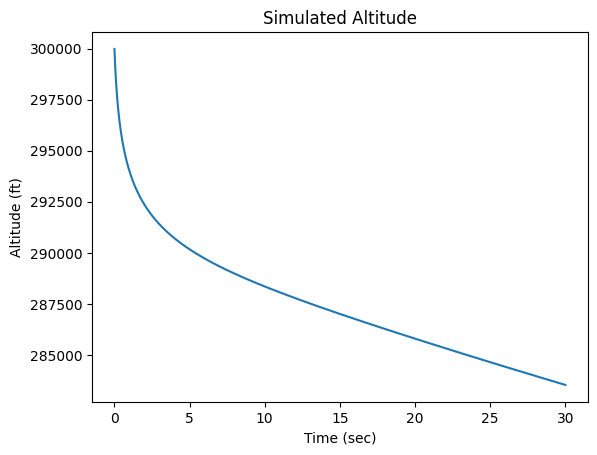

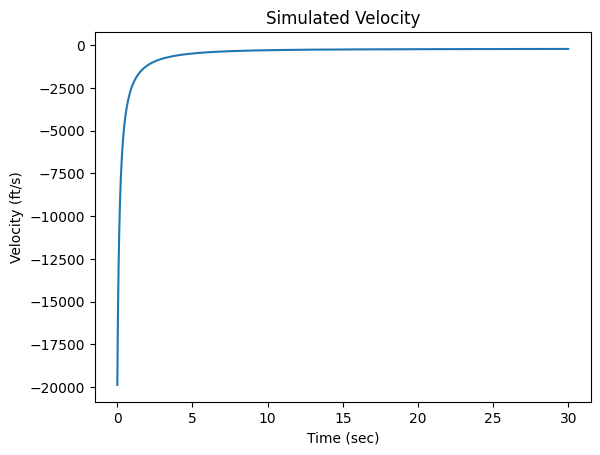

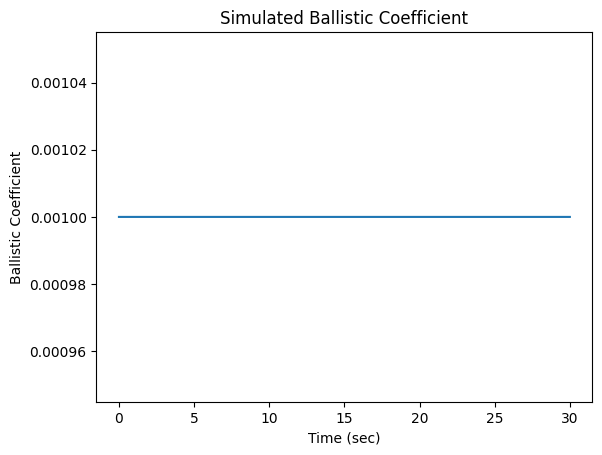

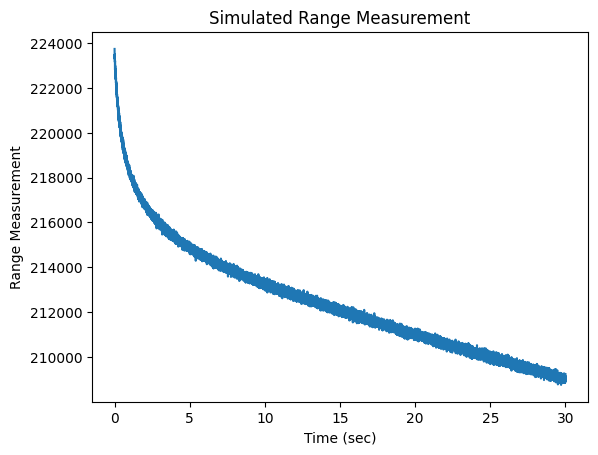

In [9]:
timestep = 0.001
t_final = 30
nsim = np.round(t_final/timestep).astype(int)

time = np.linspace(timestep,t_final, nsim)

x0 = np.array([[3e5], [-2e4], [1e-3]])
rng = np.random.default_rng()

Q = np.diag([0.0, 0.0, 0.0])
R = np.array([[10000.]])

x = x0
x_data = np.zeros((nsim.astype(int),3))
y_data = np.zeros(nsim.astype(int),)

for i in range(nsim.astype(int)):
    w_1_rand = rng.normal(0, np.sqrt(Q[0][0]))
    w_2_rand = rng.normal(0, np.sqrt(Q[1][1]))
    w_3_rand = rng.normal(0, np.sqrt(Q[2][2]))
    xdot = calculate_f_x_t(x.reshape(3,), w_1_rand, w_2_rand, w_3_rand)
    x = xdot * timestep + x
    vk_rand = rng.normal(0, np.sqrt(R[0][0]))
    y = calculate_h_x_t(x.reshape(3,), vk_rand)
    x_data[i, :] = x.T
    y_data[i] = y

plt.figure()
plt.plot(time, x_data[:,0])
plt.title("Simulated Altitude")
plt.xlabel("Time (sec)")
plt.ylabel("Altitude (ft)")

plt.figure()
plt.plot(time, x_data[:,1])
plt.title("Simulated Velocity")
plt.xlabel("Time (sec)")
plt.ylabel("Velocity (ft/s)")

plt.figure()
plt.plot(time, x_data[:,2])
plt.title("Simulated Ballistic Coefficient")
plt.xlabel("Time (sec)")
plt.ylabel("Ballistic Coefficient")

plt.figure()
plt.plot(time, y_data)
plt.title("Simulated Range Measurement")
plt.xlabel("Time (sec)")
plt.ylabel("Range Measurement")

## Hybrid Extended Kalman Filter

This Extended Kalman Filter is considered "hybrid" because it takes into account continuous time system dynamics but allows you to have a discrete measurement model, which is very often the case in practical applications. Below I'll recap the EKF equations.

Assume the following nonlinear system.

\begin{equation}
\begin{split}
    \dot{x} & = f(x, u, w, t) \\
    y_k & = h_k(x_k, v_k)
\end{split}
\end{equation}

Calculate the state derivative and integrate for the prediction step. Also, calculate the covariance derivative.

\begin{equation}
    \dot{x} = f(\hat{x}, u, 0, t)
\end{equation}

\begin{equation}
A = \frac{\partial f}{\partial x} |_{\hat{x}}
\end{equation}

\begin{equation}
L = \frac{\partial f}{\partial w} |_{\hat{x}}
\end{equation}

\begin{equation}
    \dot{P} = A P + P A^T + L Q L^T
\end{equation}

After integration, we will get an estimate for $\hat{x}_k$ and $P_k^-$.


The measurement can be taken into account using some of the discrete equations.

\begin{equation}
H = \frac{\partial h_k}{\partial x_k} |_{\hat{x}_k^-}
\end{equation}

\begin{equation}
M = \frac{\partial h_k}{\partial v_k} |_{\hat{x}_k^-}
\end{equation}

\begin{equation*}
    K_k = P_k^- H_k^T {(H_k P_k^- H_k^T - M_k R_k M_k^T)}^{-1}
\end{equation*}

\begin{equation}
    \hat{x}_k^+ = \hat{x}_k^- + K_k (y_k - h_k(\hat{x}_k^-, 0, t_k))
\end{equation}

\begin{equation}
    P_k^+ = (I - K_k H_k) P_k^- {(I - K_k H_k)}^T + K_k M_k R_k M_k^T K_k^T 
\end{equation}

In [ ]:
class extended_kalman_filter: 
    def __init__(self, f_x, h_x, A, H, M, L, Q, R, initial_state, P_inital, prediction_timestep, filter_loop_timestep):
        self.f_x = f_x
        self.h_x = h_x
        self.A = A
        self.H = H
        self.M = M
        self.L = L
        self.Q = Q
        self.R = R
        self.x = initial_state
        self.P = P_initial
        self.state_dim = len(initial_state)
        self.prediction_timestep = prediction_timestep
        self.filter_loop_timestep = filter_loop_timestep
        self.prediction_run_iterations = np.floor(filter_loop_timestep / prediction_timestep).astype(int)
        
    def run(self, measurement):
        x = self.x
        P = self.P
        for _ in range(self.prediction_run_iterations):
            x = self.f_x(x.reshape(self.state_dim,)) * self.prediction_timestep + x
            A = self.A(x.reshape(self.state_dim,)) 
            L = self.L(x.reshape(self.state_dim,))
            P_dot = A @ P + P @ A.T + L @ self.Q @ L.T
            P = P_dot * self.prediction_timestep + P

        H = self.H(x.reshape(self.state_dim,))
        M = self.M(x.reshape(self.state_dim,))
        
        K = P @ H.T @ np.linalg.inv(H @ P @ H.T + M @ self.R @ M.T)

        x_hat = x + K @ (measurement - self.h_x(x.reshape(self.state_dim,)))
        P_k_plus = (np.identity(self.state_dim) - K @ H) @ P @ (np.identity(self.state_dim) - K @ H).T + K @ M @ self.R @ M.T @ K.T

        self.x = x_hat
        self.P = P_k_plus

        return x_hat

## Unscented Kalman Filter
The UKF is interesting because it is known to have better performance than EKF for nonlinear systems. In addition, you don't need to compute Jacobians for this filter. In some situations, this might be an advantageous property of a algorithm.

The one limitation is that it may take longer to compute as there are quite a few calculations for each timestep.

Assume you have an $n$ state discrete time nonlinear system.

\begin{equation}
    \begin{split}
    x_{k+1} & = f(x_k, u_k, t_k) + w_k \\
    y_k & = h(x_k, t_k) + v_k \\
    w_k & ~ (0, Q_k) \\
    v_k & ~ (0, R_k)
    \end{split}
\end{equation}


### 1. Initialization 


\begin{equation}
\begin{split}
    \hat{x}_0^+ & = E(x_0) \\
    P_0^+ & = E[(x_0 - \hat{x}_0^+){(x_0 - \hat{x}_0^+)}^T] \\
\end{split}
\end{equation}


### 2. Propagate the state estimate

a. Choose sigma points.


\begin{equation}
\begin{split}
    x^{(i)}_{k-1} & = \hat{x}^+_{k-1} + \tilde{x}^{(i)} \text {     } i = 1, ... 2n \\
    \tilde{x}^{(i)} & = {(\sqrt{n P^+_{k-1}})}^T_i \text {     } i = 1, ... n \\
    \tilde{x}^{(n+i)} & = - {(\sqrt{n P^+_{k-1}})}^T_i \text {     } i = 1, ... n
\end{split}
\end{equation}


b. Use the nonlinear equation to transform the sigma points into the $\hat{x}_k^{(i)}$ vectors.


\begin{equation}
    \hat{x}_k^{(i)} = f(\hat{x}_{k-1}^{(i)}, u_k, t_k)
\end{equation}


c. Combine all the $\hat{x}_k^{(i)}$ vectors to form one a priori estimate a time $k$.


\begin{equation}
    \hat{x}_k^- = \frac{1}{2n} \sum_{i=1}^{2n} \hat{x}_k^{(i)}
\end{equation}


d. Estimate the a prior error covariance. 

\begin{equation}
    P_k^- = \frac{1}{2n} \sum_{i=1}^{2n} (\hat{x}_k^{(i)} - \hat{x}_k^-) {(\hat{x}_k^{(i)} - \hat{x}_k^-)} ^T + Q_{k-1}
\end{equation}

### 3. Measurement Update

a. Choose sigma points based on the propagated estimate.

\begin{equation}
    \begin{split}
        x^{(i)}_k & = \hat{x}^-_k + \tilde{x}^{(i)} \text {     } i = 1, ... 2n \\
        \tilde{x}^{(i)} & = {(\sqrt{n P^-_k})}^T_i \text {     } i = 1, ... n \\
        \tilde{x}^{(n+i)} & = - {(\sqrt{n P^-_k})}^T_i \text {     } i = 1, ... n
\end{split}
\end{equation}

b. Use the nonlinear measurement equation to transform sigma points into $\hat{y}_k^{(i)}$ predicted measurements.

\begin{equation}
    \hat{y}_k^{(i)} = h(\hat{x}_k^{(i)}, t_k)
\end{equation}

c. Combine the predicted measurement vectors into one predicted measurement at time k. 

\begin{equation}
    \hat{y}_k = \frac{1}{2n} \sum_{i=1}^{2n} \hat{y}_k^{(i)}
\end{equation}

d. Estiamte the covariance of the predicted measurement.

\begin{equation}
    P_y = \frac{1}{2n} \sum_{i=1}^{2n} (\hat{y}_k^{(i)} - \hat{y}_k) {(\hat{y}_k^{(i)} - \hat{y}_k)} ^T + R_k
\end{equation}

e. Estimate the cross covariance between $\hat{x}_k^-$ and $\hat{y}_k$.

\begin{equation}
    P_{xy} = \frac{1}{2n} \sum_{i=1}^{2n} (\hat{x}_k^{(i)} - \hat{x}_k^-) {(\hat{y}_k^{(i)} - \hat{y}_k)} ^T
\end{equation}

f. Perform remainder of measurement update.

\begin{equation}
    \begin{split}
        K_k & = P_{xy} P_y^{-1} \\
        \hat{x}_k^+ & = \hat{x}_k^- + K_k (y_k - \hat{y}_k) \\
        P_k^+ & = P_k^- - K_k P_y K_k^T
    \end{split}
\end{equation}

Note that this assumes that the process and measurement equations are linear with respect to noise.


#### Notes on the Covariance

Note that ${(\sqrt{nP})}^T$ is the matrix square root of $nP$ such that $ {(\sqrt{nP})}^T {(\sqrt{nP})}= nP$
and ${(\sqrt{nP})}_i$ is the $i$th row of $\sqrt{nP}$.

Recall the meaning of the covariance matrix. 

\begin{equation}
    P = E[(\hat{x} - x){(\hat{x} - x)}^T]
\end{equation}

Since the error covariance gives you an estimate of uncertainty in your estimate, it makes sense that you could use this number to determine the spread of sigma points around your mean.

In [11]:
class unscented_kalman_filter: 
    def __init__(self, f_x, h_x, Q, R, initial_state, initial_P, prediction_timestep, filter_loop_timestep):

        self.f_x = f_x
        self.h_x = h_x
        self.Q = Q
        self.R = R
        self.x = initial_state
        self.P = initial_P
        self.state_dim = len(initial_state)
        self.prediction_timestep = prediction_timestep
        self.filter_loop_timestep = filter_loop_timestep
        self.prediction_run_iterations = np.floor(filter_loop_timestep / prediction_timestep).astype(int)

    def calculate_sigma_points(self, x, P):
        x_tilde = np.linalg.cholesky((self.state_dim) * P)
        x_tilde_all = np.concatenate((x_tilde, -1 * x_tilde), axis=0)
        sigma_points = [x + x_tilde_all[i, :, np.newaxis] for i in range(self.state_dim * 2)]

        return sigma_points

    def run(self, measurement):

        sigma_points = self.calculate_sigma_points(self.x, self.P)
        
        # Prediction
        predicted_points = sigma_points
        for _ in range(self.prediction_run_iterations):
            for index in range(self.state_dim * 2):
                x = predicted_points[index]
                next_x = self.f_x(x.reshape(self.state_dim,)) * self.prediction_timestep + x
                predicted_points[index] = next_x
        
        # Combine into one estimate
        x_hat_a_priori = np.sum(predicted_points, axis = 0) / (self.state_dim * 2)

        # Estimate the error covariance
        P_k_minus = np.zeros((self.state_dim, self.state_dim))
        for i in range(self.state_dim * 2):
            P_k_minus += (1 / (2 * self.state_dim)) * (predicted_points[i] - x_hat_a_priori) @ (predicted_points[i] - x_hat_a_priori).T
        P_k_minus += self.Q

        sigma_points = self.calculate_sigma_points(x_hat_a_priori, P_k_minus)

        # Measurement Model
        predicted_measurements = [self.h_x(x.reshape(self.state_dim,)) for x in sigma_points]

        # Combine into one estimate
        predicted_measurement_sum = np.zeros(np.shape(measurement))
        for y in predicted_measurements:
            predicted_measurement_sum += y
            
        predicted_single_measurement = predicted_measurement_sum / (self.state_dim * 2)

        # Estimate the error covariance of the predicted measurement
        length_measurement, _ = np.shape(measurement)
        measurement_dim = length_measurement
        P_y = np.zeros((measurement_dim, measurement_dim))
        for i in range(len(predicted_measurements)):
            P_y += (1 / (2 * self.state_dim)) * (predicted_measurements[i] - predicted_single_measurement) @ (predicted_measurements[i] - predicted_single_measurement).T
        P_y += self.R

        # Estimate the cross covariance
        P_xy = np.zeros((self.state_dim, measurement_dim))
        for j in range(self.state_dim * 2):
            P_xy += (1 / (2 * self.state_dim)) * (predicted_points[j] - x_hat_a_priori) @ (predicted_measurements[j] - predicted_single_measurement).T
        
        K = P_xy @ np.linalg.inv(P_y)
        xhat = x_hat_a_priori + K @ (measurement - predicted_single_measurement)
        P_k_plus = P_k_minus - K @ P_y @ K.T

        self.P = P_k_plus
        self.x = xhat

        return xhat

    def get_P(self):
        return self.P
        

## Compare Filter Performance

Next, the filters are simulated using the fake generated data. Note that some special logic is done to run the prediction step at a period of 0.001 sec while processing the measurement update step every 0.2 sec.

In [ ]:
# Create a EKF
P_initial = np.diag([1000000., 4000000., 10.])
ekf_timestep = 0.2
ekf = extended_kalman_filter(calculate_f_x_t_no_noise, calculate_h_x_t_no_noise, get_A, get_H, get_M, get_L, Q, R, x0, P_initial, timestep, ekf_timestep)

# Create an UKF
ukf_timestep = 0.2 # 0.1
ukf = unscented_kalman_filter(calculate_f_x_t_no_noise, calculate_h_x_t_no_noise, Q, R, x0, P_initial, timestep, ukf_timestep)

# Simulate EKF
nsim_ekf = np.round(t_final/ekf_timestep).astype(int)
ekf_timestep_ratio = np.round(ekf_timestep/timestep).astype(int) 
ekf_timepoint = np.linspace(ekf_timestep,t_final, nsim_ekf)
ekf_estimate = np.zeros((nsim_ekf.astype(int),3))
ekf_offset = ekf_timestep_ratio - 1


for i in range(nsim_ekf):
    ekf_estimate[i, :] = ekf.run(np.array([[y_data[i * ekf_timestep_ratio + ekf_offset]]])).T

# Simulate UKF
nsim_ukf = np.round(t_final/ukf_timestep).astype(int)
ukf_timestep_ratio = np.round(ukf_timestep/timestep).astype(int) 
ukf_timepoint = np.linspace(ukf_timestep,t_final, nsim_ukf)
ukf_estimate = np.zeros((nsim_ukf.astype(int),3))
ukf_offset = ukf_timestep_ratio - 1

for i in range(nsim_ukf):
    ukf_estimate[i, :] = ukf.run(np.array([[y_data[i * ukf_timestep_ratio + ukf_offset]]])).T

Text(0.5, 1.0, 'Ballistic Coefficient')

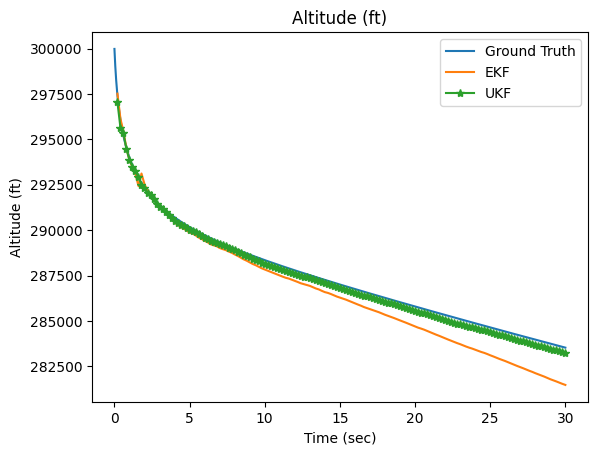

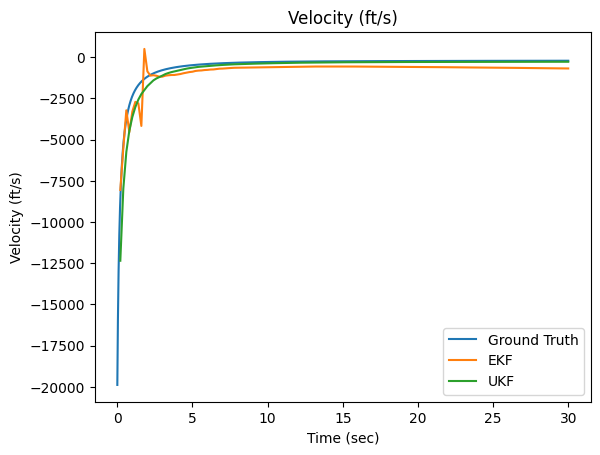

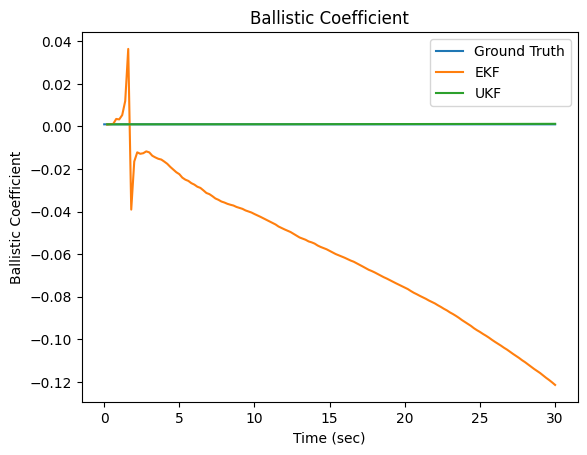

In [13]:
plt.figure()
plt.plot(time, x_data[:,0], label='Ground Truth')
plt.plot(ekf_timepoint, ekf_estimate[:,0], label='EKF')
plt.plot(ukf_timepoint, ukf_estimate[:,0], label='UKF', marker='*')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude (ft)')

plt.figure()
plt.plot(time, x_data[:,1], label='Ground Truth')
plt.plot(ekf_timepoint, ekf_estimate[:,1], label='EKF')
plt.plot(ukf_timepoint, ukf_estimate[:,1], label='UKF')
plt.legend()
plt.ylabel('Velocity (ft/s)')
plt.title('Velocity (ft/s)')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(time, x_data[:,2], label='Ground Truth')
plt.plot(ekf_timepoint, ekf_estimate[:,2], label='EKF')
plt.plot(ukf_timepoint, ukf_estimate[:,2], label='UKF')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Ballistic Coefficient')
plt.title('Ballistic Coefficient')

The results show EKF being quite noisier than the UKF, particularly with a lot of spikes around 10 sec. For a better view of the results, we can plot just the errors between the estimate and ground truth.

Text(0.5, 1.0, 'Ballistic Coefficient Error')

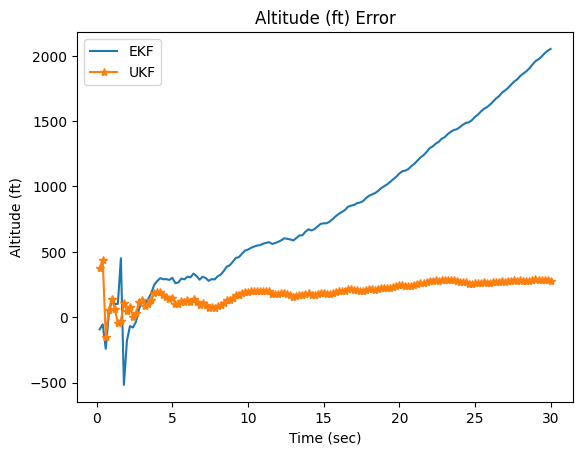

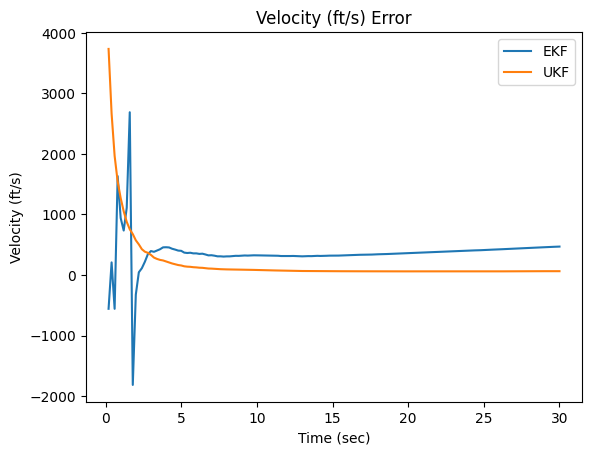

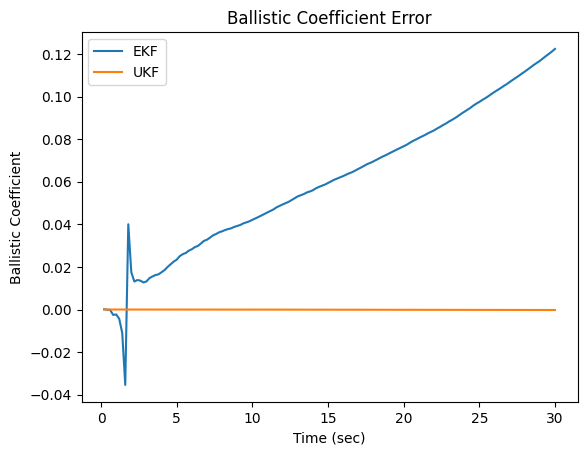

In [14]:
ukf_error = np.zeros((nsim_ukf.astype(int), 3))
for i in range(nsim_ukf):
    ukf_error[i, :] = (x_data[i * ukf_timestep_ratio + ukf_offset, :] - ukf_estimate[i,:]).T


ekf_error = np.ones((nsim_ekf.astype(int), 3))
for i in range(nsim_ekf):
    ekf_error[i, :] = (x_data[i * ekf_timestep_ratio + ekf_offset, :] - ekf_estimate[i,:]).T

plt.figure()
plt.plot(ekf_timepoint, ekf_error[:,0], label='EKF')
plt.plot(ukf_timepoint, ukf_error[:,0], label='UKF', marker='*')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Altitude (ft)')
plt.title('Altitude (ft) Error')

plt.figure()
plt.plot(ekf_timepoint, ekf_error[:,1], label='EKF')
plt.plot(ukf_timepoint, ukf_error[:,1], label='UKF')
plt.legend()
plt.ylabel('Velocity (ft/s)')
plt.title('Velocity (ft/s) Error')
plt.xlabel('Time (sec)')

plt.figure()
plt.plot(ekf_timepoint, ekf_error[:,2], label='EKF')
plt.plot(ukf_timepoint, ukf_error[:,2], label='UKF')
plt.legend()
plt.xlabel('Time (sec)')
plt.ylabel('Ballistic Coefficient')
plt.title('Ballistic Coefficient Error')


The error plot even further demonstrates how the UKF performs better than the EKF. The UKF has much less error and also a smoother estimate of the states.

These results follows expectations given what we know about these algorithms. The EKF uses a first order linearization to update the covariance of the state and mean of the state. In contrast, the UKF estimates the nonlinearities by using these sigma points. These points help bring the UKF to a third order approximation of its Taylor series.

## Closing Thoughts

While it can be fun to write everything yourself, it's not always the best decision. In some projects, it's better to utilize existing libraries that have been well tested and take advantage of the collective efforts of open source projects. 

While I did write these filters by hand for the learning experience, I think a good next step would be to try these out using a library like `PyKalman`.

## Sources

1. *Optimal Estimation* by Dan Simon
2. [Dan Simon's Overiew of State Estimation](https://academic.csuohio.edu/simon-daniel/state-estimation/) *Note link this contains the MATLAB code for examples in his book.* I do deviate from his implementations slightly in addition to running everything in Python instead of MATLAB. However, feel free to check out the Dan Simon's original implementations.